In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [ ]:
def show_tensor_image(image_tensor, num_image = 25 , size = (1,28,28)):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_image],nrow = 5)
    plt.imshow(image_grid.permute(1,2,0))
    plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self,z_dim = 10,im_chan=1,hidden_dim=64):
        super(Generator,self).__init__()
        self.z_dim = z_dim #noise vector dimension
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim,hidden_dim*4),
            self.make_gen_block(hidden_dim*4,hidden_dim*2,kernel = 4,stride = 1),
            self.make_gen_block(hidden_dim*2,hidden_dim),
            self.make_gen_block(hidden_dim,im_chan,kernel = 4,final_layer = True),
        
        )
    def make_gen_block(self,input_channel,output_channel,kernel = 3,stride = 2,final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel,output_channel,kernel,stride=stride),
                nn.BatchNorm2d(output_channel),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel,output_channel,kernel,stride=stride)
            )
    def unsqeeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    def forward(self,noise):
        x = self.unsqeeze_noise(noise)
        return self.gen(x)
def get_noise(n_sample,z_dim,device='cpu'):
    return torch.randn(n_sample,z_dim,device = device)
    


In [ ]:
class Descreminator(nn.Module):
    def __init__(self,im_chan = 1, hidden_dim = 16):
        super(Descreminator,self).__init__()
        self.disc = nn.Sequential(
                self.make_disc_block(im_chan,hidden_dim),
                self.make_disc_block(hidden_dim,hidden_dim*2),
                self.make_disc_block(hidden_dim*2,1,final_layer = True))
        
    def make_disc_block(self,input_channel,output_channel,kernel_size = 4,stride = 2, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel,output_channel,kernel_size,stride = stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2)
                )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel,output_channel,kernel_size,stride = stride)
                )
    def forward(self,image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred),-1)


In [ ]:
#training part

criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128

#a Learning rate of 0.0002 works well on DCGAN
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cpu'

# you can transform the image value to be b/w -1 and 1 (the range of tanh activation function)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
dataloader = DataLoader(MNIST('.',download = True,transform = transforms.ToTensor()),
                       batch_size = batch_size,
                       shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
#you can intialize your generator discriptor and Optimiser

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr = lr,betas=(beta_1,beta_2))
disc = Descreminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr = lr, betas=(beta_1,beta_2))

#initialize the weights to the normal distribution with mean 0 and std 0.02
def weight_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        nn.init.normal_(m.weight,0.0,0.02)
    if isinstance(m,nn.BatchNorm2d):
        nn.init.normal_(m.weight,0.0,0.02)
        nn.init.constant(m.bias,0)
gen = gen.apply(weight_init)
disc = disc.apply(weight_init)
        


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1, step:500,Generator loss : 0.0017619235515594482, discriminator loss : 0.6192578728795048 


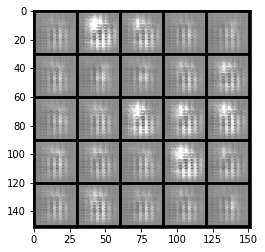

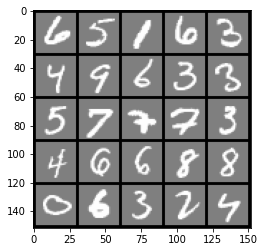

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2, step:1000,Generator loss : 0.0014252521991729736, discriminator loss : 0.5926340366005894 


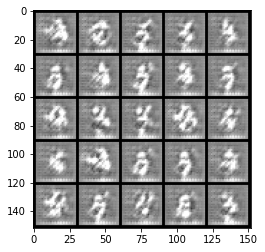

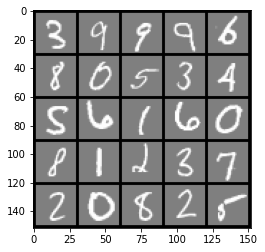

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3, step:1500,Generator loss : 0.0017982180118560791, discriminator loss : 0.5350006421208378 


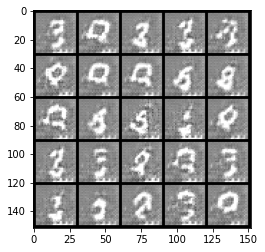

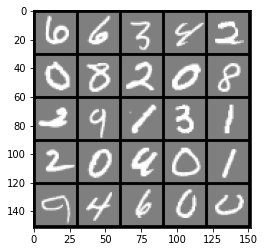

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4, step:2000,Generator loss : 0.0015056657791137696, discriminator loss : 0.4754069384932517 


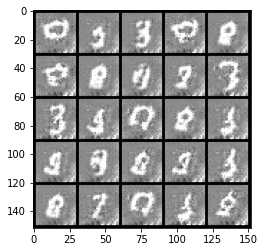

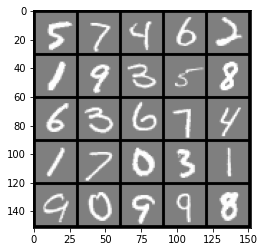

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5, step:2500,Generator loss : 0.0022017502784729003, discriminator loss : 0.4309453719258308 


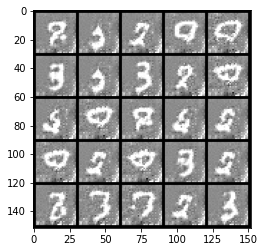

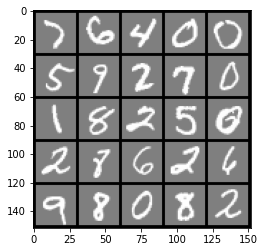

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6, step:3000,Generator loss : 0.002558470726013184, discriminator loss : 0.4077643870115282 


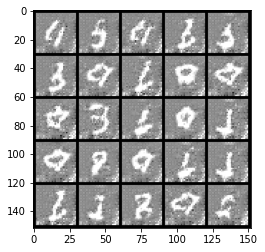

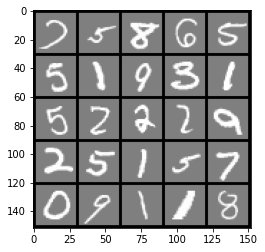

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7, step:3500,Generator loss : 0.002728015422821045, discriminator loss : 0.40317201489210114 


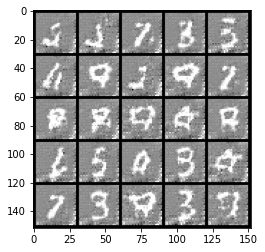

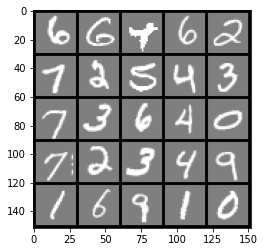

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8, step:4000,Generator loss : 0.0014681752920150757, discriminator loss : 0.40665107202529915 


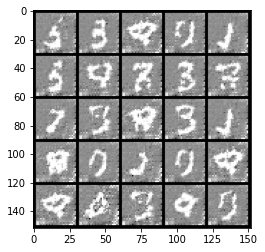

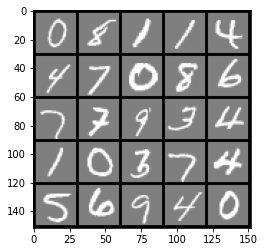

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9, step:4500,Generator loss : 0.0026996083259582518, discriminator loss : 0.42922151994705204 


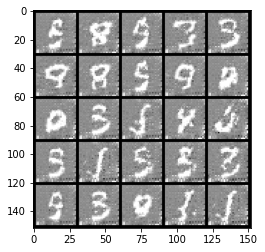

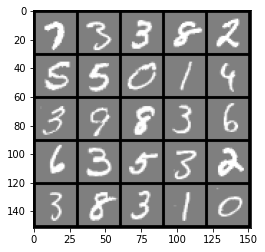

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10, step:5000,Generator loss : 0.002021497011184692, discriminator loss : 0.44021502816677166 


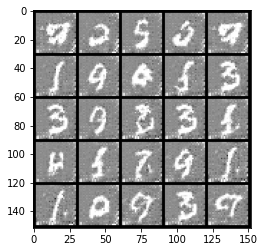

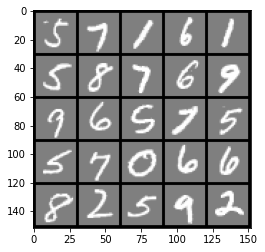

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11, step:5500,Generator loss : 0.0023600592613220216, discriminator loss : 0.4722635719776152 


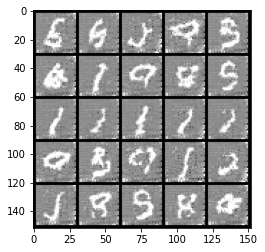

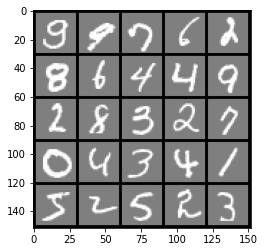

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12, step:6000,Generator loss : 0.0018777996301651, discriminator loss : 0.48541398823261234 


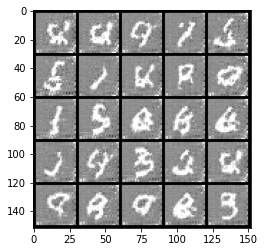

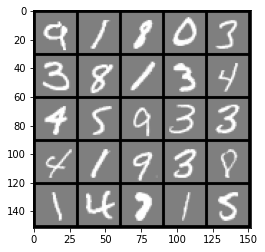

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13, step:6500,Generator loss : 0.001723687171936035, discriminator loss : 0.5071987978219985 


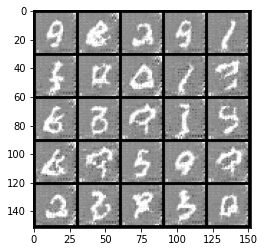

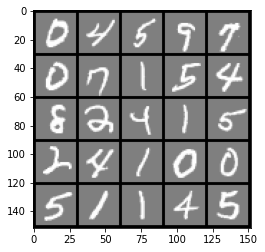

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14, step:7000,Generator loss : 0.002417613744735718, discriminator loss : 0.5432725719809535 


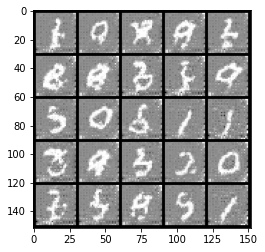

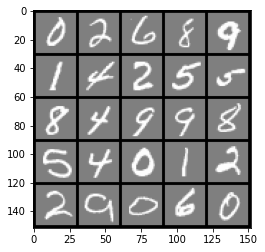

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15, step:7500,Generator loss : 0.0020081253051757813, discriminator loss : 0.5604683443307877 


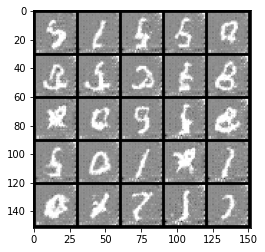

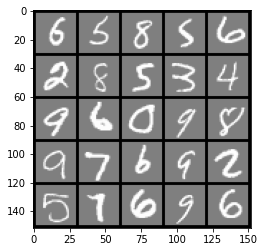

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17, step:8000,Generator loss : 0.0020971267223358152, discriminator loss : 0.5806777956485745 


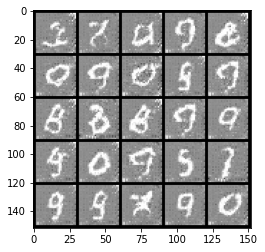

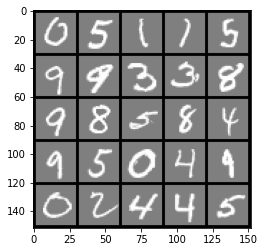

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18, step:8500,Generator loss : 0.001836922526359558, discriminator loss : 0.5909616935253142 


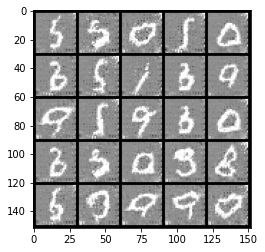

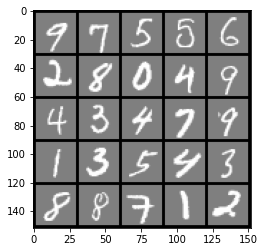

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19, step:9000,Generator loss : 0.0023004860877990723, discriminator loss : 0.6069361555576324 


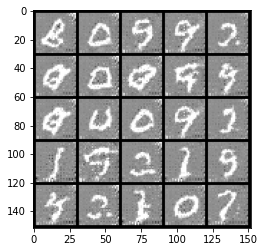

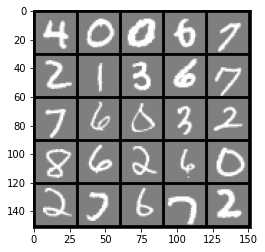

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20, step:9500,Generator loss : 0.0020770401954650877, discriminator loss : 0.6253546764850619 


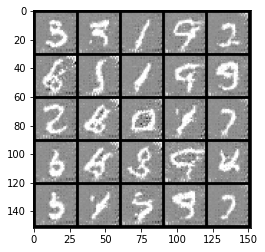

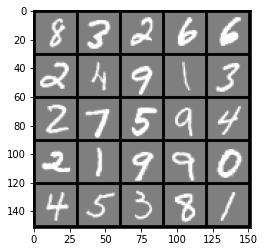

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21, step:10000,Generator loss : 0.001558295488357544, discriminator loss : 0.6346293720006937 


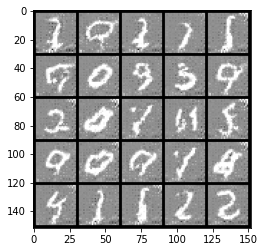

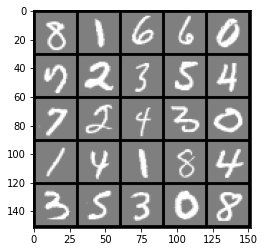

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:22, step:10500,Generator loss : 0.00149200701713562, discriminator loss : 0.6354906275272373 


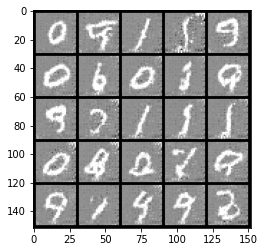

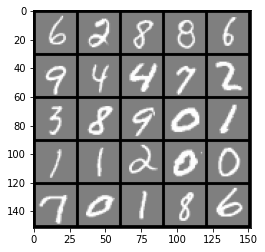

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:23, step:11000,Generator loss : 0.001886067509651184, discriminator loss : 0.6425855072736736 


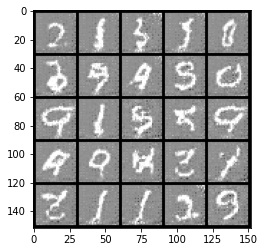

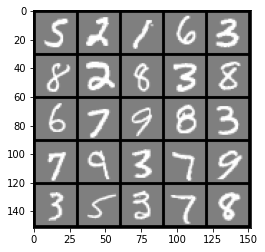

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:24, step:11500,Generator loss : 0.0017762454748153687, discriminator loss : 0.6434109239578252 


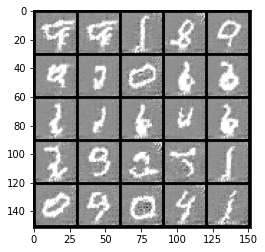

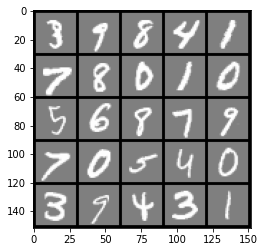

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:25, step:12000,Generator loss : 0.0012868292331695557, discriminator loss : 0.6459391572475431 


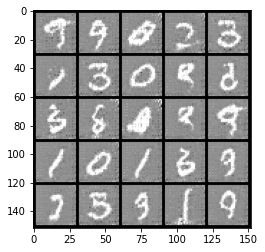

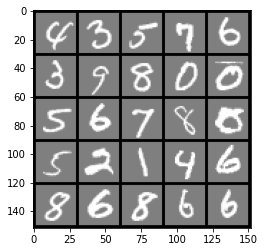

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:26, step:12500,Generator loss : 0.0012009409666061401, discriminator loss : 0.650259158372879 


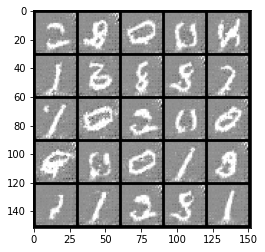

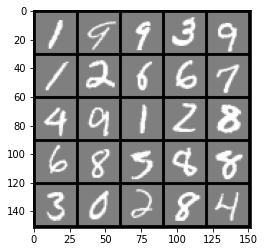

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:27, step:13000,Generator loss : 0.0011739922761917114, discriminator loss : 0.6521885150670998 


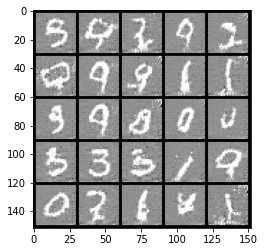

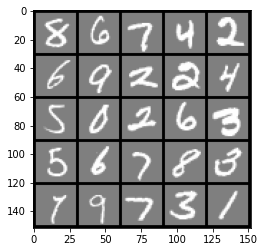

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:28, step:13500,Generator loss : 0.0018433842658996582, discriminator loss : 0.655503960490227 


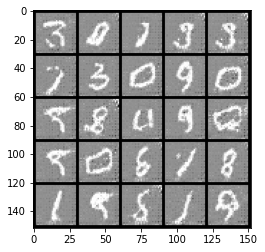

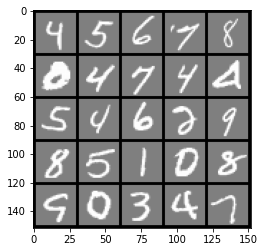

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:29, step:14000,Generator loss : 0.001790949583053589, discriminator loss : 0.6552143476009373 


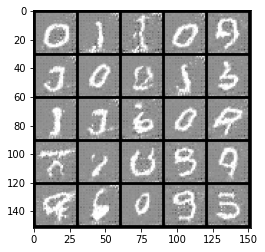

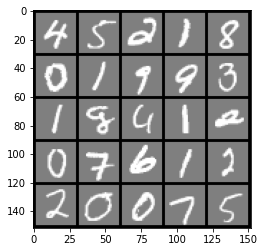

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:30, step:14500,Generator loss : 0.001984647274017334, discriminator loss : 0.659875098228454 


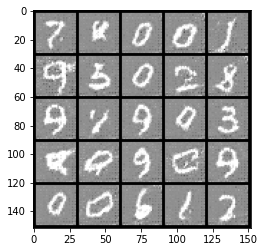

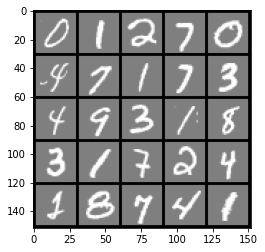

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:31, step:15000,Generator loss : 0.0016520512104034424, discriminator loss : 0.6643418513536451 


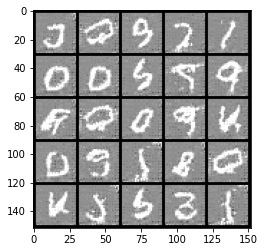

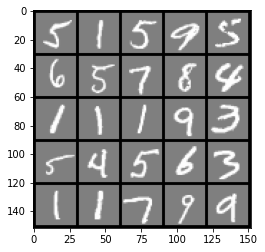

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:33, step:15500,Generator loss : 0.001084096908569336, discriminator loss : 0.6690389281511304 


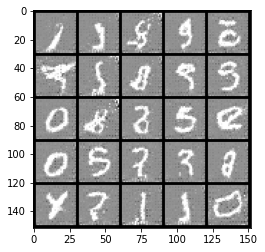

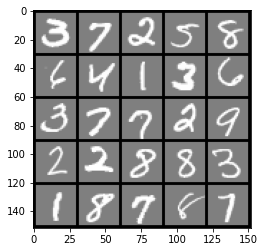

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:34, step:16000,Generator loss : 0.0013700755834579468, discriminator loss : 0.6694686862230308 


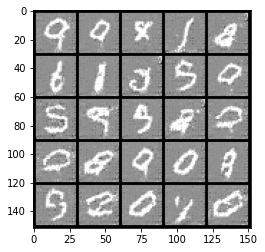

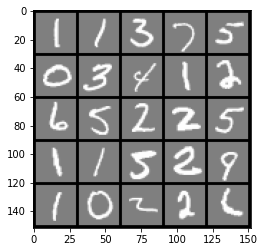

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:35, step:16500,Generator loss : 0.0011265460252761841, discriminator loss : 0.6716470156908037 


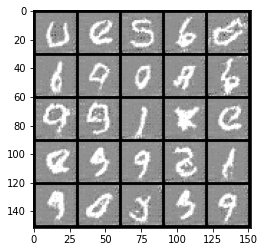

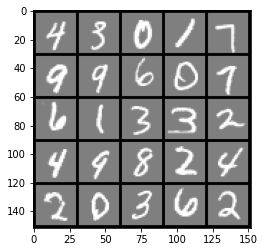

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:36, step:17000,Generator loss : 0.0016608113050460816, discriminator loss : 0.67788012111187 


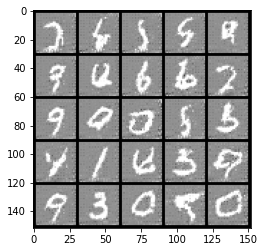

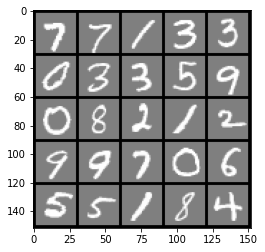

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:37, step:17500,Generator loss : 0.00152483069896698, discriminator loss : 0.6776711597442628 


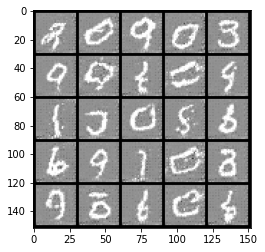

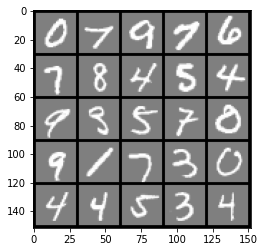

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:38, step:18000,Generator loss : 0.0015274758338928223, discriminator loss : 0.6766189748048776 


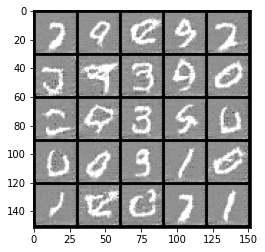

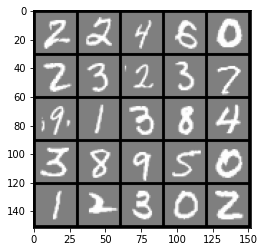

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:39, step:18500,Generator loss : 0.001428689479827881, discriminator loss : 0.6796957858800892 


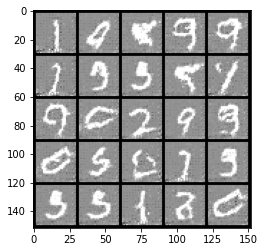

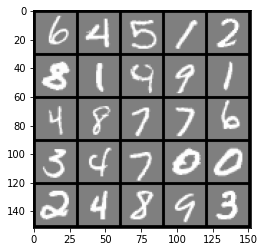

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:40, step:19000,Generator loss : 0.0015863531827926636, discriminator loss : 0.6820868924856186 


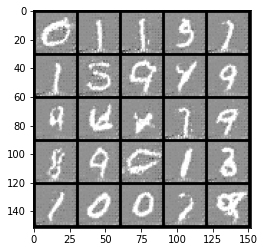

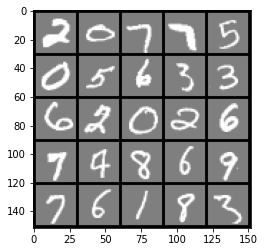

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:41, step:19500,Generator loss : 0.0012756041288375854, discriminator loss : 0.6833967229127886 


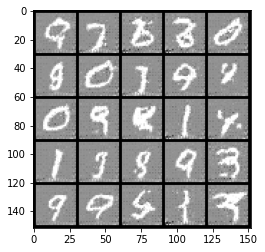

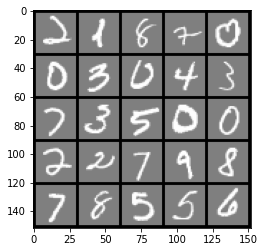

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:42, step:20000,Generator loss : 0.0011706823110580445, discriminator loss : 0.6851291580200193 


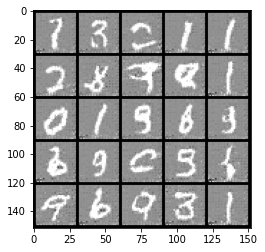

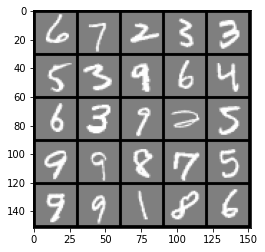

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:43, step:20500,Generator loss : 0.001580306053161621, discriminator loss : 0.6874346119165424 


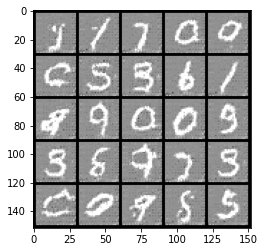

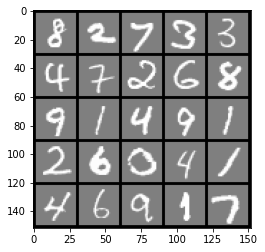

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:44, step:21000,Generator loss : 0.0015209563970565796, discriminator loss : 0.689035360097886 


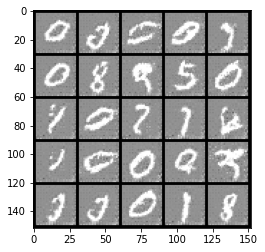

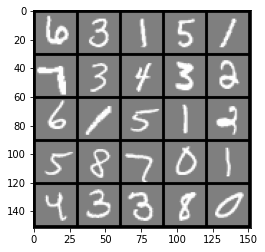

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:45, step:21500,Generator loss : 0.0014418966770172118, discriminator loss : 0.6908435826301573 


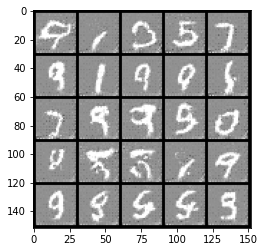

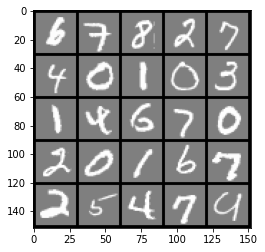

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:46, step:22000,Generator loss : 0.0011725045442581177, discriminator loss : 0.6911164708137513 


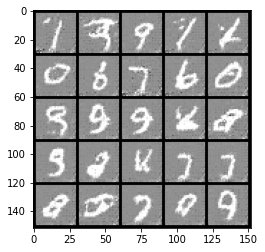

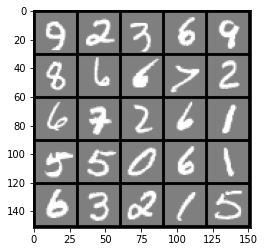

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:47, step:22500,Generator loss : 0.00144170880317688, discriminator loss : 0.689683309912682 


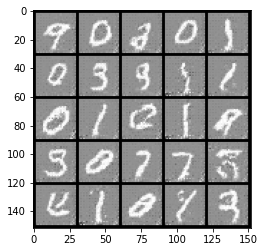

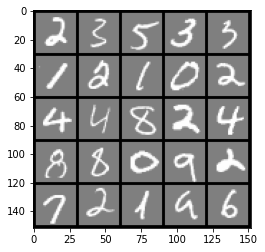

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:49, step:23000,Generator loss : 0.0016082161664962768, discriminator loss : 0.6937511446475993 


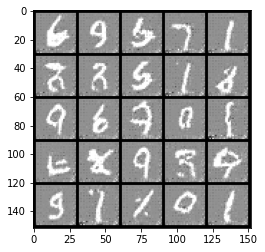

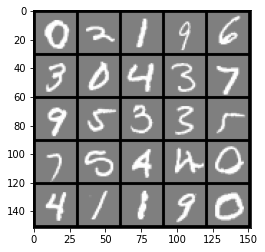

In [7]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_descriminator_loss = 0

for epoch in range(n_epochs):
    for real,_ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        ##update descriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device = device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)/2 
        
        #keep track of the average descriminator loss
        mean_descriminator_loss += disc_loss.item() / display_step
        #update gradient
        disc_loss.backward(retain_graph = True)
        #update optimiser
        disc_opt.step()
        
        ##update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device = device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        #keep track of theaverage generator loss
        mean_generator_loss = gen_loss.item() / display_step
        
        ##visualization code##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch:{epoch}, step:{cur_step},Generator loss : {mean_generator_loss}, discriminator loss : {mean_descriminator_loss} ")
            show_tensor_image(fake)
            show_tensor_image(real)
            mean_generator_loss = 0
            mean_descriminator_loss = 0
        cur_step += 1
        
        